In [1]:
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm as tqdm
from keras.models import load_model
from keras import backend as K
from datetime import datetime

from Dental_Tool.Inception_v3 import Custom_Inception_V3, Simple_Inception
from Dental_Tool.Inception import create_inception_v4
from Dental_Tool.Data_processing import *
from Dental_Tool.Dental_Model import *
from Dental_Tool.Process_results import *
from Dental_Tool.Dataloader import *

import keras.backend as K 
import matplotlib.pyplot as plt
import numpy as np
import keras
import time

Using TensorFlow backend.


In [2]:
# Sheng_ID = ["002555 042513 x", "000408 102419 x", "005627 120209 x", "004151 091409 x",
#             "003615 010816 x", "007274 021016 x", "007274 021016 x", "004359 030716 x",
#             "001742 082712 x", "002456 060517 x", "1899 120718 x", "004499 110515 x",
#             "13529 092513 x",  "000411 112119 x", "008908 090309 x", "003262 103015 x",
#             "10689 102418 x", "003670 020718 x", "010953 031618 x", ]

In [3]:
def Inception_Multitask(input_shape):
        input_tensor = Input(shape=input_shape)
        base_model = InceptionV3(input_tensor=input_tensor, include_top=False, weights=None)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        
        class_branch = Dense(3, activation='softmax', name='class_output')(x)
        HV_branch = Dense(3, activation='softmax', name='HV_output')(x)

        model = Model(inputs=input_tensor, outputs=[HV_branch, class_branch])
        
#         regularizer = l2(0.00001)

#         for layer in base_model.layers:
#                 for attr in ['kernel_regularizer']:
#                         if hasattr(layer, attr):
#                                 setattr(layer, attr, regularizer)
        
        opt = keras.optimizers.RMSprop(lr=1e-3)
        model.compile(optimizer='rmsprop',
              loss={
                    'class_output': 'categorical_crossentropy', 
                    'HV_output'   : 'categorical_crossentropy'
                   },
              loss_weights={'class_output': .70, 'HV_output': 0.15},
              metrics=['accuracy']
             )
    
        return model
    
model = Inception_Multitask(input_shape=(200, 180, 1))

In [4]:
class DataGenerator(keras.utils.Sequence):
        'Generates data for Keras'
        def __init__(self, list_IDs, labels, batch_size=32, dim=(256, 256), n_channels=1,
                     n_classes=10, shuffle=True, resize_setting=(256, 256)):
                'Initialization'
                self.dim = dim
                self.batch_size = batch_size
                self.labels = labels
                self.list_IDs = list(list_IDs)
                self.n_channels = n_channels
                self.n_classes = n_classes
                self.shuffle = shuffle
                self.on_epoch_end()
                self.resize_setting = resize_setting
                

        def __len__(self):
                'Denotes the number of batches per epoch'
                return int(np.ceil(len(self.list_IDs) / self.batch_size))

        def __getitem__(self, index):
                'Generate one batch of data'
                # Generate indexes of the batch
                end = (index+1)*self.batch_size if (index+1)*self.batch_size < len(self.indexes) else len(self.indexes)
                indexes = self.indexes[index*self.batch_size:end] 

                # Find list of IDs
                list_IDs_temp = [self.list_IDs[k] for k in indexes]         
                # Generate data
                X, y = self.__data_generation(list_IDs_temp)
                return X, y

        def on_epoch_end(self):
                'Updates indexes after each epoch'
                self.indexes = np.arange(len(self.list_IDs))
                if self.shuffle == True:
                        np.random.shuffle(self.indexes)
        
        def noisy_image(self, noise_typ, image):
                if noise_typ == "gauss":
                          row,col= image.shape
                          mean = 0
                          var = 0.1
                          sigma = var**0.5
                          gauss = np.random.normal(mean,sigma,(row,col))
                          gauss = gauss.reshape(row,col)
                          noisy = image + gauss
                          return noisy

                elif noise_typ == "s&p":
                          row,col = image.shape
                          s_vs_p = 0.5
                          amount = 0.004
                          out = np.copy(image)
                          # Salt mode
                          num_salt = np.ceil(amount * image.size * s_vs_p)
                          coords = [np.random.randint(0, i - 1, int(num_salt))
                                  for i in image.shape]
                          out[coords] = 1

                          # Pepper mode
                          num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
                          coords = [np.random.randint(0, i - 1, int(num_pepper))
                                  for i in image.shape]
                          out[coords] = 0
                          return out

                elif noise_typ == "poisson":
                          vals = len(np.unique(image))
                          vals = 2 ** np.ceil(np.log2(vals))
                          noisy = np.random.poisson(image * vals) / float(vals)
                          return noisy

                elif noise_typ == "speckle":
                          row,col = image.shape
                          gauss = np.random.randn(row,col)
                          gauss = gauss.reshape(row,col)        
                          noisy = image + image * gauss
                          return noisy
            
        def __data_generation(self, list_IDs_temp):
            
                # Initialization
                image_array_size = ( self.batch_size, *self.dim, self.n_channels )
                X = np.zeros(image_array_size, dtype=np.uint8)
                y_HV = np.array([0]* self.batch_size)
                y_class = np.array([0]* self.batch_size)
                y_fur   = np.array([0]* self.batch_size)
                
                for i, ID in enumerate(list_IDs_temp):
                        image = cv2.imread(ID, 0)
                        image = cv2.resize(image, (self.resize_setting[1], self.resize_setting[0]))
                        
#                         from random import sample
#                         random_index = sample(range(0, 32), k=8)
                
#                         if i in random_index: image = self.noisy_image("gauss", image)
                        image = np.reshape(image, (*image.shape, 1))
                        X[i,], y_class[i], y_HV[i] =  image, self.labels[ID][0], self.labels[ID][1]
                class_output =  to_categorical(y_class, num_classes=self.n_classes)
                HV_output = to_categorical(y_HV, num_classes=self.n_classes) 
                
                return_y = { 'HV_output': HV_output, 'class_output':class_output}
                return X, [HV_output, class_output]

In [5]:
def make_generator_multitask(dataset, batch_size=32):
        common_params = {
                              'batch_size': batch_size,
                              'n_classes' : len(np.unique(dataset.Class)),
                              'n_channels': 1,
                              'shuffle'   : False,
                              'resize_setting': (200, 180),
                              'dim': (200, 180)
        }
        
        dataset_dict = collections.OrderedDict(zip(dataset.Path, dataset.Class))
        
        for idx, item in dataset.iterrows():
                dataset_dict[item["Path"]] = [ item["Class"], item["bone_loss"]]
                
        dataset_generator = DataGenerator(dataset["Path"], dataset_dict ,**common_params)
        return dataset_generator
    


In [6]:
def plot_result_Multitask(history, output_dir):
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(16,5))
#         loss: 0.4421 
#         HV_output_loss: 0.6354 
#         class_output_loss: 0.3522 
#         HV_output_accuracy: 0.7014
#         class_output_accuracy: 0.8612 
                            
#         val_loss: 1.2021 
#         val_HV_output_loss: 0.9517
#         val_class_output_loss: 1.1634 
#         val_HV_output_accuracy: 0.6368 
#         val_class_output_accuracy: 0.6930
        
        plt.subplot(121)
        plt.title("Loss")
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['HV_output_loss'], label='HV Training Loss')
        plt.plot(history.history['class_output_loss'], label='Class Training Loss')
        
        plt.plot(history.history['val_loss'], label = 'Validation Loss')
        plt.plot(history.history['val_HV_output_loss'], label = 'HV Validation Loss')
        plt.plot(history.history['val_class_output_loss'], label = 'Class Validation Loss')
        
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='lower right')
        
        plt.subplot(122)
        plt.title("Accuracy")
        plt.plot(history.history['HV_output_accuracy'], label='HV Training Accuracy')
        plt.plot(history.history['class_output_accuracy'], label='Class Training Accuracy')
        
        plt.plot(history.history['val_HV_output_accuracy'], label = 'HV Validation Accuracy')
        plt.plot(history.history['val_class_output_accuracy'], label = 'Class Validation Accuracy')
        
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0.1, 1.5])
        plt.legend(loc='lower right')
        
#         target_dir = "Results/%s" % (output_dir)
        if not os.path.isdir(output_dir): os.makedirs(output_dir)
        plt.savefig("%s/history.png" % (output_dir))
        plt.show()

Fold 1: loading Inception_Multitask ......
Fold 1: loading Done, cost 3.6396493911743164 seconds
Epoch 1/15
1108/1108 [==============================] - 2338s 2s/step - loss: 0.5902 - HV_output_loss: 0.7634 - class_output_loss: 0.6795 - HV_output_accuracy: 0.6616 - class_output_accuracy: 0.7007 - val_loss: 2.5197 - val_HV_output_loss: 0.8035 - val_class_output_loss: 0.9901 - val_HV_output_accuracy: 0.6559 - val_class_output_accuracy: 0.6606

Epoch 00001: val_class_output_accuracy improved from -inf to 0.66062, saving model to Results/Inception_Three_new_Balance_Common_Multi_Class3_Meng_Sheng_Chang_Fold_520201125-083749/Fold_1/Inception_Multitask_Fold_1/parameter/weights-improvement-01-0.6606.hdf5
Epoch 2/15
1108/1108 [==============================] - 305s 275ms/step - loss: 0.3020 - HV_output_loss: 0.6337 - class_output_loss: 0.2956 - HV_output_accuracy: 0.7050 - class_output_accuracy: 0.8865 - val_loss: 2.9648 - val_HV_output_loss: 0.8316 - val_class_output_loss: 1.6962 - val_HV_outp

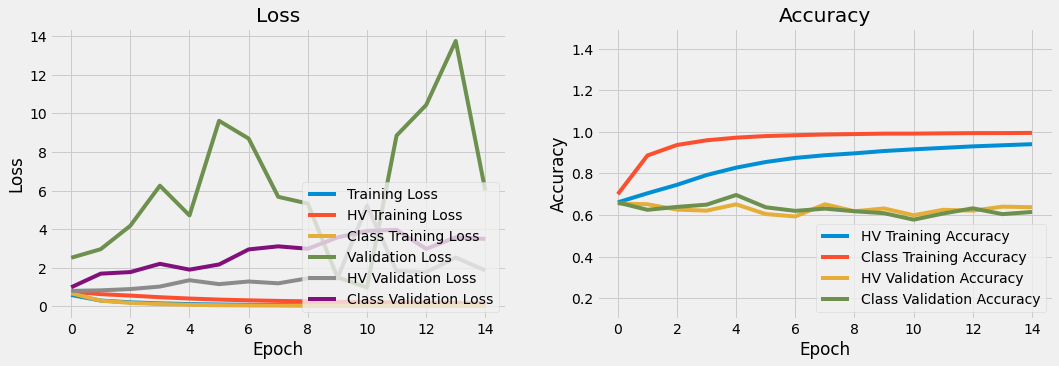

loading Results/Inception_Three_new_Balance_Common_Multi_Class3_Meng_Sheng_Chang_Fold_520201125-083749/Fold_1/Inception_Multitask_Fold_1/parameter\weights-improvement-05-0.6968.hdf5 ......
loading Done, cost 58.6837694644928 seconds
341/341 [==============================] - 788s 2s/step
Accuracy  = 69.64 %


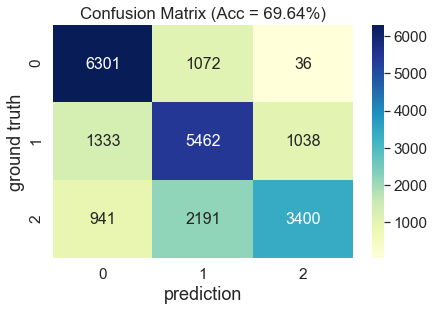

  Class 0 Class 1 Class 2  Acc
0    3818     194       3  95%
1    2483     878      33  73%
2    1333    5462    1038  70%
3     941    2191    3400  52%
Fold 2: loading Inception_Multitask ......
Fold 2: loading Done, cost 4.281202077865601 seconds
Epoch 1/15
1054/1054 [==============================] - 1085s 1s/step - loss: 0.6074 - HV_output_loss: 0.7673 - class_output_loss: 0.7033 - HV_output_accuracy: 0.6679 - class_output_accuracy: 0.6970 - val_loss: 0.7364 - val_HV_output_loss: 0.7067 - val_class_output_loss: 0.8574 - val_HV_output_accuracy: 0.6938 - val_class_output_accuracy: 0.6792

Epoch 00001: val_class_output_accuracy improved from -inf to 0.67916, saving model to Results/Inception_Three_new_Balance_Common_Multi_Class3_Meng_Sheng_Chang_Fold_520201125-083749/Fold_2/Inception_Multitask_Fold_2/parameter/weights-improvement-01-0.6792.hdf5
Epoch 2/15
1054/1054 [==============================] - 294s 279ms/step - loss: 0.3327 - HV_output_loss: 0.6534 - class_output_loss: 0.3353 

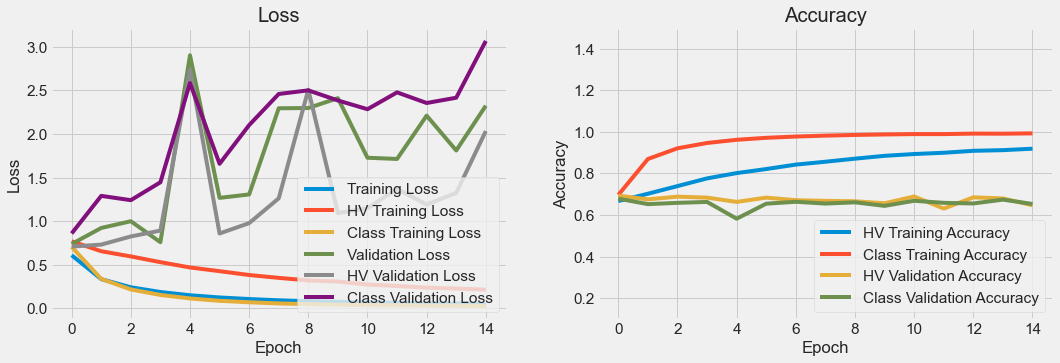

loading Results/Inception_Three_new_Balance_Common_Multi_Class3_Meng_Sheng_Chang_Fold_520201125-083749/Fold_2/Inception_Multitask_Fold_2/parameter\weights-improvement-01-0.6792.hdf5 ......
loading Done, cost 85.69844436645508 seconds
378/378 [==============================] - 799s 2s/step
Accuracy  = 71.11 %


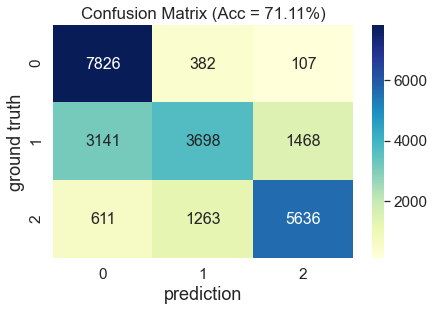

  Class 0 Class 1 Class 2  Acc
0    3831      66      72  97%
1    3995     316      35  92%
2    3141    3698    1468  45%
3     611    1263    5636  75%
Fold 3: loading Inception_Multitask ......
Fold 3: loading Done, cost 3.336357831954956 seconds
Epoch 1/15
1047/1047 [==============================] - 1928s 2s/step - loss: 0.6660 - HV_output_loss: 0.7820 - class_output_loss: 0.7838 - HV_output_accuracy: 0.6679 - class_output_accuracy: 0.6478 - val_loss: 1.9005 - val_HV_output_loss: 0.8591 - val_class_output_loss: 0.8332 - val_HV_output_accuracy: 0.6424 - val_class_output_accuracy: 0.6857

Epoch 00001: val_class_output_accuracy improved from -inf to 0.68572, saving model to Results/Inception_Three_new_Balance_Common_Multi_Class3_Meng_Sheng_Chang_Fold_520201125-083749/Fold_3/Inception_Multitask_Fold_3/parameter/weights-improvement-01-0.6857.hdf5
Epoch 2/15
1047/1047 [==============================] - 330s 315ms/step - loss: 0.3683 - HV_output_loss: 0.6718 - class_output_loss: 0.3822 

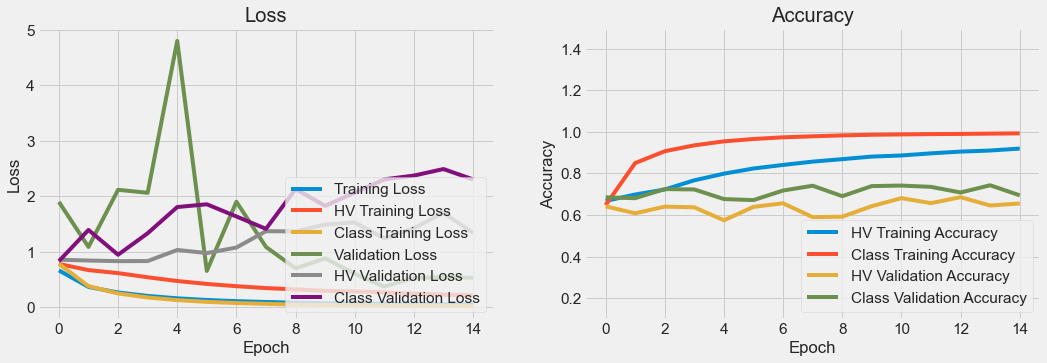

loading Results/Inception_Three_new_Balance_Common_Multi_Class3_Meng_Sheng_Chang_Fold_520201125-083749/Fold_3/Inception_Multitask_Fold_3/parameter\weights-improvement-14-0.7436.hdf5 ......
loading Done, cost 91.8538908958435 seconds
344/344 [==============================] - 736s 2s/step
Accuracy  = 71.54 %


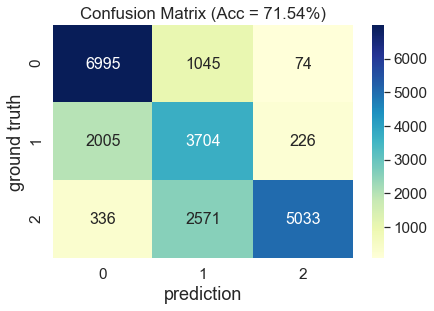

  Class 0 Class 1 Class 2  Acc
0    3936     141      32  96%
1    3059     904      42  76%
2    2005    3704     226  62%
3     336    2571    5033  63%
Fold 4: loading Inception_Multitask ......
Fold 4: loading Done, cost 3.3304572105407715 seconds
Epoch 1/15
1028/1028 [==============================] - 1611s 2s/step - loss: 0.6033 - HV_output_loss: 0.7822 - class_output_loss: 0.6943 - HV_output_accuracy: 0.6595 - class_output_accuracy: 0.6987 - val_loss: 0.8570 - val_HV_output_loss: 0.8827 - val_class_output_loss: 1.2851 - val_HV_output_accuracy: 0.6278 - val_class_output_accuracy: 0.6831

Epoch 00001: val_class_output_accuracy improved from -inf to 0.68314, saving model to Results/Inception_Three_new_Balance_Common_Multi_Class3_Meng_Sheng_Chang_Fold_520201125-083749/Fold_4/Inception_Multitask_Fold_4/parameter/weights-improvement-01-0.6831.hdf5
Epoch 2/15
1028/1028 [==============================] - 317s 308ms/step - loss: 0.3258 - HV_output_loss: 0.6826 - class_output_loss: 0.3192

In [ ]:
# all_models = { "CNN_Net": CNN_Net, "Inception": Inception, "ResNet": ResNet }

model_info = ("Inception_Multitask", Inception_Multitask)

performance_list = []

epochs     = 15
Fold_num = 5
classes = 3
num_params = 1
fold_data_num = 1

# data_src = f"Class_{classes}_3P_multitask"
# path = f"balance_dataset/{data_src}"

dir_name = "Multi_Class3_Meng_Sheng_Chang"
# dir_name = "Multi_Class3_All_Chang"
# dir_name = "Multi_Class3_Chang_Majority"


path = f"balance_dataset/Common_Dataset/{dir_name}"
root_dir  =  f"Inception_Three_new_Balance_Common_{dir_name}_Fold_5" + datetime.now().strftime("%Y%m%d-%H%M%S")
init_directory(f"Results/{root_dir}/table")

for train_dataset, valid_dataset, test_dataset, train_generator, valid_generator, test_generator in\
        prepared_data(path, classes, Fold_num, batch_size=64):
        
#         train_dataset = train_dataset[~train_dataset.ID.isin(Sheng_ID)]
#         valid_dataset = valid_dataset[~valid_dataset.ID.isin(Sheng_ID)]
#         test_dataset  = test_dataset [~test_dataset.ID.isin(Sheng_ID)]
        
        train_generator = make_generator_multitask(train_dataset, batch_size=64)
        valid_generator = make_generator_multitask(valid_dataset, batch_size=64)
        test_generator  = make_generator_multitask(test_dataset, batch_size=64)
        
        
        
        K.clear_session()
        best_models = None
        
        model_name, model_fnc = model_info
        K.clear_session()

        param_dir  = f"{model_name}_Fold_{fold_data_num}"
        print(f"Fold {fold_data_num}: loading {model_name} ......")

        start = time.time()
        model = model_fnc(input_shape=(200, 180, 1))
        end = time.time()
        elapse = end - start
        print(f"Fold {fold_data_num}: loading Done, cost {elapse} seconds")


        init_directory(f"Results/{root_dir}/Fold_{fold_data_num}/{param_dir}/parameter")

        filepath="Results/%s/Fold_%d/%s/parameter/weights-improvement-{epoch:02d}-{val_class_output_accuracy:.4f}.hdf5" \
                    %(root_dir, fold_data_num, param_dir)
        checkpoint = ModelCheckpoint(filepath, monitor='val_class_output_accuracy', verbose=1, save_best_only=True, mode='max')

        # change 
        history = model.fit_generator(
                                generator=train_generator,
                                validation_data=valid_generator,
                                epochs=epochs,
                                workers=2,
                                shuffle=True,
                                verbose=1,
                                callbacks=[checkpoint]
                               )
        plot_result_Multitask(history, f"Results/{root_dir}/Fold_{fold_data_num}/{param_dir}")

        K.clear_session()
        top_k_param = get_k_top_value(f"Results/{root_dir}/Fold_{fold_data_num}/{param_dir}/parameter",  k_th = num_params )
        best_param = top_k_param[0]
        
        K.clear_session()
        print(f"loading {best_param} ......")
        start = time.time()
        best_model = load_model(best_param)
        end = time.time()
        elapse = end - start
        print(f"loading Done, cost {elapse} seconds")

        test_predict = best_model.predict_generator(test_generator, verbose=1)
        test_predict = test_predict[1][:len(test_dataset)]
        test_result  = np.argmax(test_predict, axis=1)
        
        test_dataset["Predict"] = test_result
        
        K.clear_session()
        
        confusion = confusion_matrix(test_dataset.Class.astype('int'), test_result.astype('int'))
        curr_acc = (test_dataset.Class == test_dataset.Predict).mean() * 100
        title = "Accuracy  = {:5.2f} %".format(curr_acc)
        print(title)
        init_directory(f"Results/{root_dir}/Fold_{fold_data_num}/table")
        plot_confusion_matrix(confusion, len(np.unique(test_dataset.Class)), curr_acc, f"Results/{root_dir}/Fold_{fold_data_num}", 0)
        
        test_predict = np.round(test_predict, 2)
        
#         test_dataset[f"{model_name}_Prob"] = pd.Series(test_predict.tolist())
        test_dataset[['Class_0_prob', 'Class_1_prob', 'Class_2_prob']] = pd.DataFrame(test_predict)
        test_dataset["Predict"] = test_result
        
        test_dataset.to_csv(f"Results/{root_dir}/Fold_{fold_data_num}/table/test_predict.csv", index=False)
        detail = statistic(test_dataset)
        detail.to_csv(f"Results/{root_dir}/Fold_{fold_data_num}/table/cmx_stage.csv")
        print(detail)
        
        
        K.clear_session()
        
        performance_list.append(curr_acc)
        fold_data_num += 1

In [ ]:
total_score = np.mean(performance_list)
title = "Accuracy  = {:5.2f} %".format(total_score)
title